In [ ]:
# Copyright (c) 2023 Sophie Katz
#
# This file is part of Language Model.
#
# Language Model is free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later version.
#
# Language Model is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
# PARTICULAR PURPOSE. See the GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License along with Language
# Model. If not, see <https://www.gnu.org/licenses/>.

# Writing a transformer from scratch using Pytorch

In this notebook, I'm writing a minimal implementation of a transformer from scratch in Pytorch. The goal is to understand the transformer architecture. I'm using the transformer architecture described in the paper [Attention is all you need](https://arxiv.org/abs/1706.03762).

## Resources used

Name | URL
---- | ---
A video tutorial going through the paper | https://www.youtube.com/watch?v=U0s0f995w1
Tutorial for simple architecture | https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51

## Architecture

Transformer's architecture as a whole looks rather intimidating at first. Here's a diagram of the architecture taken from the paper:

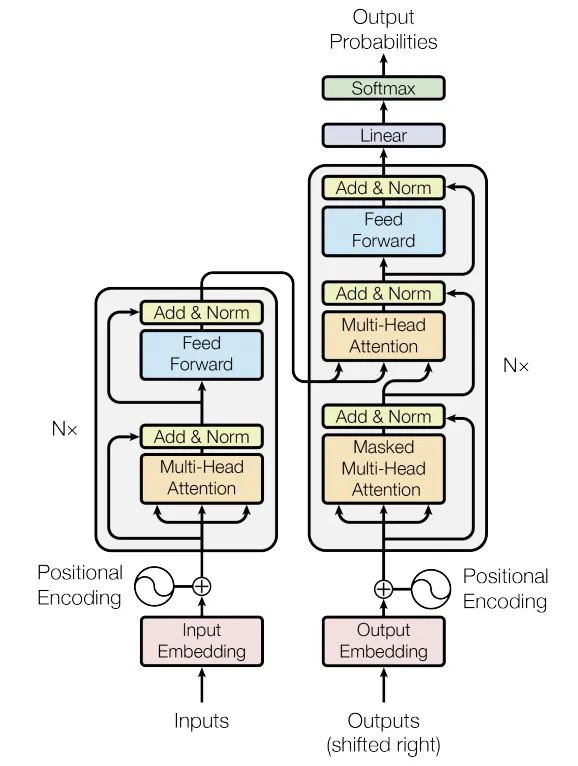

We can break it down into simpler concepts, though. It's an encoder-decoder architecture at its core, but it uses two novel techniques: **attention** and **positional encoding**.

### Attention

We start by implementing scaled dot product attention, which is the first step towards implementing a multi-head attention block.

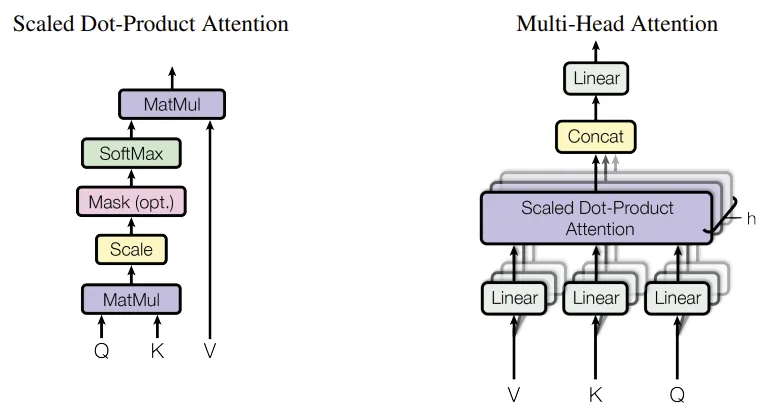

Scaled dot product attention roughly follows this formula:

$$attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

Where:
- $Q$ are the query matrices
- $K$ are the key matrices
- $V$ are the value matrices

$Q$, $K$, and $V$ are all batches of matrices with shapes `(batch_size, sequence_length, feature_count)`. If we multiply $Q$ and $K^T$ together, we get an array with shape `(batch_size, sequence_length, sequence_length)` which is our attention for this layer. The softmax allows us to use attentions in the range of $[0, 1]$. Finally, attention is applied to $V$ using matrix multiplication.

Let's start by importing Pytorch:

In [3]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

Let's create some example $Q$, $K$, and $V$ matrices and see how attention would look like with them:

In [ ]:
batch_size = 64
source_sequence_length = 13
target_sequence_length = 8
feature_count = 512

queries = T.rand(batch_size, target_sequence_length, feature_count)

And then let's write our scaled dot product attention function:

In [2]:
def attention(query: T.Tensor, key: T.Tensor, value: T.Tensor) -> T.Tensor:
    """
    Compute attention for a single head.

    Parameters
    ==========
    query: T.Tensor
        The query tensor of shape (batch_size, out_seq_len, d_model).
    key: T.Tensor
        The key tensor of shape (batch_size, in_seq_len, d_model).
    value: T.Tensor
        The value tensor of shape (batch_size, in_seq_len, d_model).
    """

    assert len(query.shape) == 3

    batch_size, sequence_length, feature_count = query.shape

    assert query.shape == key.shape
    assert query.shape == value.shape

    # key.transpose(1, 2) has shape (batch_size, d_model, in_seq_len)
    # query.bmm(key.transpose(1, 2)) has shape (batch_size, out_seq_len, in_seq_len)
    # query.size(-1) is the feature count
    # weights have shape (batch_size, out_seq_len, in_seq_len)

    # attention is the weights matrix multiplied by the value matrix
    # it has shape (batch_size, out_seq_len, d_model)

    # attention should have shape (batch_size, out_seq_len, in_seq_len)

    return F.softmax(query.bmm(key.transpose(1, 2)) / query.size(-1) ** 0.5).bmm(value)

In [7]:
class SelfAttentionModule(nn.Module):
    def __init__(self, embedding_size, head_count):
        super().__init__()

        self.embedding_size = embedding_size
        self.head_count = head_count
        self.head_dimension = self.embedding_size // self.head_count

        assert (
            self.head_dimension * self.head_count == self.embedding_size
        ), "embedding size must be divisible by head count"

        self.layer_values = nn.Linear(
            self.head_dimension, self.head_dimension, bias=False
        )
        self.layer_keys = nn.Linear(
            self.head_dimension, self.head_dimension, bias=False
        )
        self.layer_queries = nn.Linear(
            self.head_dimension, self.head_dimension, bias=False
        )
        self.layer_fc_out = nn.Linear(self.embedding_size, self.embedding_size)

    def forward(self, values, keys, queries, mask):
        batch_size = queries.shape[0]
        values_length = values.shape[1]
        keys_length = keys.shape[1]
        queries_length = queries.shape[1]

        values = values.reshape(
            batch_size, values_length, self.head_count, self.head_dimension
        )

        keys = keys.reshape(
            batch_size, keys_length, self.head_count, self.head_dimension
        )

        queries = queries.reshape(
            batch_size, queries_length, self.head_count, self.head_dimension
        )

        
